In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [6]:
!kaggle datasets download -d theeyeschico/indian-food-classification

 99% 1.65G/1.67G [00:14<00:00, 166MB/s]
100% 1.67G/1.67G [00:14<00:00, 122MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('indian-food-classification.zip')
zip_ref.extractall()
zip_ref.close()

In [8]:
for dirpath, dirnames, filenames in os.walk('/content/dataset/Dataset'):
  print(f'{len(dirnames)}, {len(filenames)}, {dirpath}')

2, 0, /content/dataset/Dataset
20, 0, /content/dataset/Dataset/train
0, 179, /content/dataset/Dataset/train/pakode
0, 225, /content/dataset/Dataset/train/momos
0, 134, /content/dataset/Dataset/train/kulfi
0, 187, /content/dataset/Dataset/train/masala_dosa
0, 167, /content/dataset/Dataset/train/dhokla
0, 210, /content/dataset/Dataset/train/pav_bhaji
0, 184, /content/dataset/Dataset/train/pizza
0, 228, /content/dataset/Dataset/train/kadai_paneer
0, 261, /content/dataset/Dataset/train/chole_bhature
0, 85, /content/dataset/Dataset/train/paani_puri
0, 217, /content/dataset/Dataset/train/butter_naan
0, 194, /content/dataset/Dataset/train/jalebi
0, 191, /content/dataset/Dataset/train/kaathi_rolls
0, 164, /content/dataset/Dataset/train/samosa
0, 233, /content/dataset/Dataset/train/burger
0, 207, /content/dataset/Dataset/train/idli
0, 247, /content/dataset/Dataset/train/chai
0, 203, /content/dataset/Dataset/train/dal_makhani
0, 230, /content/dataset/Dataset/train/chapati
0, 250, /content/datase

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = 'dataset/Dataset/train/'
test_dir = 'dataset/Dataset/val/'


train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)



print("Training Images : ")
train_data = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')
print("Testing Images : ")
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

Training Images : 
Found 3996 images belonging to 20 classes.
Testing Images : 
Found 1250 images belonging to 20 classes.


In [10]:
import datetime


def create_tb_callback(dir_name, exp_name):
  log_dir = dir_name + '/' + exp_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to {log_dir}')
  return tensorboard_callback

In [11]:
efficient_net = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
resnet = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

In [12]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

In [14]:
def create_model(model_url,num_classes=20):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))
  
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [15]:
resnet_model = create_model(resnet,
                            num_classes=train_data.num_classes)

In [16]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 20)                40980     
Total params: 23,605,780
Trainable params: 40,980
Non-trainable params: 23,564,800
_________________________________________________________________


In [17]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [19]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tb_callback(dir_name='tensorflow_hub',
                                                                exp_name='resnet50V2'
                                                                )])

Saving TensorBoard log files to tensorflow_hub/resnet50V2/20211016-173602
Epoch 1/5
 14/125 [==>...........................] - ETA: 1:35 - loss: 3.0102 - accuracy: 0.1406

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 38/125 [========>.....................] - ETA: 1:12 - loss: 2.1528 - accuracy: 0.4005

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


125/125 [==============================] - 179s 1s/step - loss: 1.2149 - accuracy: 0.6594 - val_loss: 0.6152 - val_accuracy: 0.8240
Epoch 2/5
125/125 [==============================] - 143s 1s/step - loss: 0.4214 - accuracy: 0.8889 - val_loss: 0.5191 - val_accuracy: 0.8488
Epoch 3/5
125/125 [==============================] - 143s 1s/step - loss: 0.2834 - accuracy: 0.9312 - val_loss: 0.5018 - val_accuracy: 0.8488
Epoch 4/5
125/125 [==============================] - 142s 1s/step - loss: 0.2022 - accuracy: 0.9587 - val_loss: 0.4471 - val_accuracy: 0.8720
Epoch 5/5
125/125 [==============================] - 140s 1s/step - loss: 0.1498 - accuracy: 0.9745 - val_loss: 0.4393 - val_accuracy: 0.8712


In [20]:
import matplotlib.pyplot as plt


def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']


  epochs = range(len(history.history['loss']))
  plt.figure(figsize=(20,6))
  plt.subplot(1,2,1)
  plt.plot(epochs,loss, label='training_loss')
  plt.plot(epochs,val_loss, label='val_loss')


  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()




  plt.subplot(1,2,2)
  plt.plot(epochs, acc, label='training_accuracy')
  plt.plot(epochs, val_acc, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

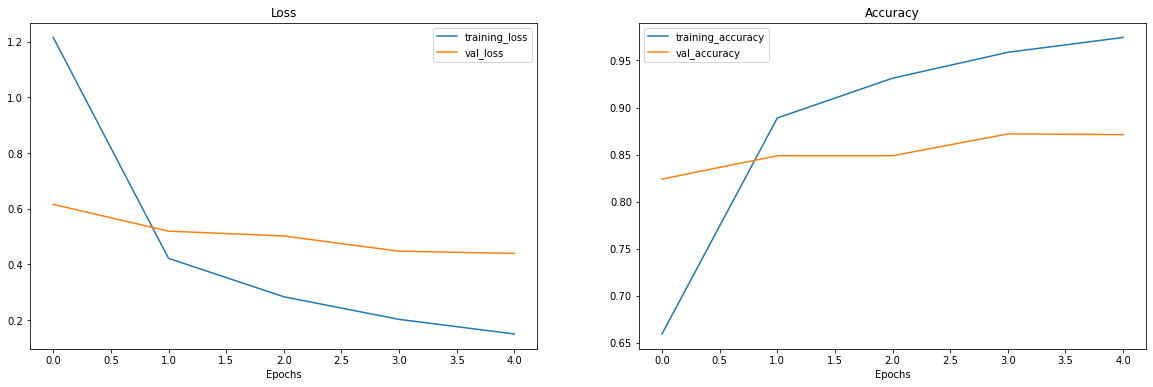

In [21]:
plot_loss_curves(resnet_history)

In [22]:
efficientnet_model = create_model(efficient_net,
                            num_classes=train_data.num_classes)

In [23]:
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [24]:
efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs=3,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tb_callback(dir_name='tensorflow_hub',
                                                                exp_name='efficientnetb0'
                                                                )])

Saving TensorBoard log files to tensorflow_hub/efficientnetb0/20211016-175047
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


 11/125 [=>............................] - ETA: 1:55 - loss: 2.8754 - accuracy: 0.1449

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


125/125 [==============================] - 149s 1s/step - loss: 1.3002 - accuracy: 0.7265 - val_loss: 0.6547 - val_accuracy: 0.8688
Epoch 2/3
125/125 [==============================] - 132s 1s/step - loss: 0.4399 - accuracy: 0.9174 - val_loss: 0.4366 - val_accuracy: 0.9048
Epoch 3/3
125/125 [==============================] - 134s 1s/step - loss: 0.2946 - accuracy: 0.9427 - val_loss: 0.3581 - val_accuracy: 0.9184


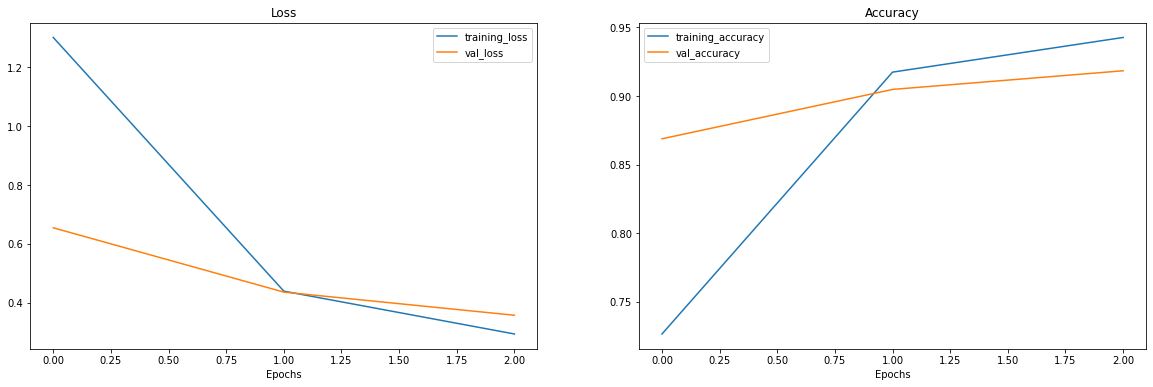

In [25]:
plot_loss_curves(efficientnet_history)

In [37]:
efficientnet_model.evaluate(test_data)

40/40 [==============================] - 33s 818ms/step - loss: 0.3581 - accuracy: 0.9184


[0.35812434554100037, 0.91839998960495]

In [40]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['burger' 'butter_naan' 'chai' 'chapati' 'chole_bhature' 'dal_makhani'
 'dhokla' 'fried_rice' 'idli' 'jalebi' 'kaathi_rolls' 'kadai_paneer'
 'kulfi' 'masala_dosa' 'momos' 'paani_puri' 'pakode' 'pav_bhaji' 'pizza'
 'samosa']


In [45]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [46]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

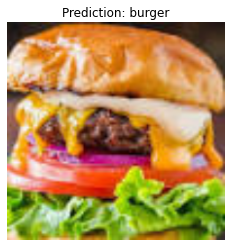

In [47]:
pred_and_plot(efficientnet_model, "pre.jpg", class_names)

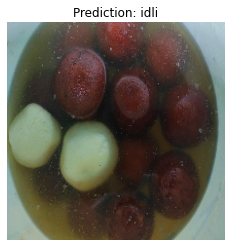

In [50]:
pred_and_plot(efficientnet_model, "am.jpeg", class_names)

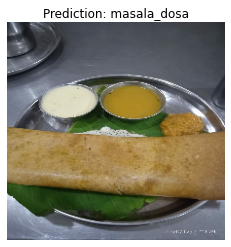

In [51]:
pred_and_plot(efficientnet_model, "pm.jpeg", class_names)


In [ ]:
#Run the following code to visualize the above created models into tensorboard

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'Food Vision - EfficientNetB0 vs. ResNet50V2' \
  --description 'Comparison between the two ' \
  --one_shot